Criação de um modelo supervisionado de classificação para prever se um pedido será entregue no prazo
para isso, precisa ser feito a classificação de pedidos entregues no prazo vs atrasados

## Importações

In [13]:
# Importar bibliotecas principais para análise e modelagem
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


## Carregando o dataset

In [14]:
# Carregar a tabela consolidada criada no ETL
df = pd.read_parquet("/home/felipe/Desktop/Projetos Free ml/Brazilian_E-Commerce/data/processed/orders_table.parquet")

# Visualizar primeiras linhas
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,delivery_time_days,estimated_time_days,delay,total_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,housewares,8.0,15,0,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,housewares,8.0,15,0,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,housewares,8.0,15,0,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,13.0,19.0,31570.0,belo horizonte,SP,perfumery,13.0,19,0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.0,21.0,14840.0,guariba,SP,auto,9.0,26,0,179.12


## Seleção de features e target

Não selecionamos todas as features por enquanto, mas podemos ir adicionando mais
essas são as mais relevantes até então

In [15]:
# Definir target (variável que queremos prever)
y = df["delay"]

# Features selecionadas (ajustaremos depois se necessário)
features = [
    "total_price", "freight_value", "payment_type", "payment_installments", 
    "review_score", "product_category_name_english", 
    "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm",
    "customer_state", "delivery_time_days", "estimated_time_days"
]

X = df[features]


## Divisão em treino e teste

In [16]:
# Dividir os dados em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (95314, 13)
Tamanho teste: (23829, 13)


## Variaveis categóricas e numéricas

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   total_price                    118310 non-null  float64
 1   freight_value                  118310 non-null  float64
 2   payment_type                   119140 non-null  object 
 3   payment_installments           119140 non-null  float64
 4   review_score                   118146 non-null  float64
 5   product_category_name_english  116576 non-null  object 
 6   product_weight_g               118290 non-null  float64
 7   product_length_cm              118290 non-null  float64
 8   product_height_cm              118290 non-null  float64
 9   product_width_cm               118290 non-null  float64
 10  customer_state                 119143 non-null  object 
 11  delivery_time_days             115722 non-null  float64
 12  estimated_time_days           

verificando se há valores faltantes para não atraplhar a normalização e treinamento

In [26]:
X.isnull().sum().sort_values(ascending=False)


delivery_time_days               3421
product_category_name_english    2567
review_score                      997
product_weight_g                  853
product_length_cm                 853
product_height_cm                 853
product_width_cm                  853
total_price                       833
freight_value                     833
payment_type                        3
payment_installments                3
customer_state                      0
estimated_time_days                 0
dtype: int64

Como existem valores faltantes, irei trata-los de forma rudimentar, com a média para colunas numéricas e o "mais frequente" nas categórias

In [27]:
from sklearn.impute import SimpleImputer

# 1. Tratar valores faltantes nas colunas numéricas
imputer_numeric = SimpleImputer(strategy='median')
X_train[numeric] = imputer_numeric.fit_transform(X_train[numeric])
X_test[numeric] = imputer_numeric.transform(X_test[numeric])

# 2. Tratar valores faltantes nas colunas categóricas
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_train[categorical] = imputer_categorical.fit_transform(X_train[categorical])
X_test[categorical] = imputer_categorical.transform(X_test[categorical])

Pré processamento com pipeline e normalização 

In [28]:
# Identificar colunas categóricas e numéricas
categorical = ["payment_type", "product_category_name_english", "customer_state"]
numeric = [col for col in X.columns if col not in categorical]

# Transformações
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),           # Normaliza numéricos
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)  # Codifica categóricos
    ]
)


## Modelo baseline

In [29]:
# Pipeline com pré-processamento + modelo
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Treinar modelo
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]


## Relatório das métricas

métricas:
    - Precision
    - Recall
    - F1

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22135
           1       0.98      0.98      0.98      1694

    accuracy                           1.00     23829
   macro avg       0.99      0.99      0.99     23829
weighted avg       1.00      1.00      1.00     23829

ROC AUC: 0.9996483689627005


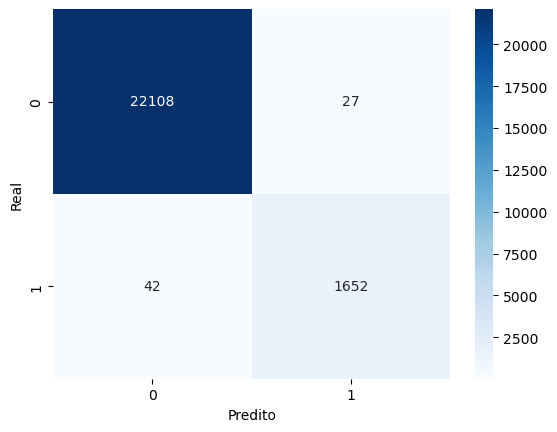

In [30]:
# Relatório de métricas
print(classification_report(y_test, y_pred))

# AUC
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
